In [ ]:
# -*- coding: utf-8 -*-

!pip3 install torchdiffeq

import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser('ODE demo')

parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000) #size of true_y and pred_y and t (n of timepoints for the diff eq in odeint)
parser.add_argument('--batch_time', type=int, default=10) #batch_t takes the first batch_time(=10) first elements of t
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args = parser.parse_args(args=[])

from torchdiffeq import odeint_adjoint as odeint
from scipy.integrate import odeint as odeint_standard

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')


Pv loop simulator (and returns v_i):

In [ ]:
### ODE: for each t (here fixed), gives dy/dt as a function of y(t) at that t, so can be used for integrating the vector y over time
#it is run for each t going from 0 to tmax
def heart_ode(y, t, Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc):
    x1, x2, x3, x4, x5 = y #here y is a vector of 5 values (not functions), at time t, used for getting (dy/dt)(t)
    P_lv = Plv(x1,Emax,Emin,t,Tc)
    dydt = [r(x2-P_lv)/Rm-r(P_lv-x4)/Ra, (x3-x2)/(Rs*Cr)-r(x2-P_lv)/(Cr*Rm), (x2-x3)/(Rs*Cs)+x5/Cs, -x5/Ca+r(P_lv-x4)/(Ca*Ra), (x4-x3-Rc*x5)/Ls]
    return dydt

def r(u):
    return max(u, 0.)

#returns Plv at time t using Elastance(t) and Vlv(t)-Vd=x1
def Plv(x1, Emax, Emin, t, Tc):
    return Elastance(Emax,Emin,t, Tc)*x1

#returns Elastance(t)
def Elastance(Emax,Emin,t, Tc):
    t = t-int(t/Tc)*Tc #can remove this if only want 1st ED (and the 1st ES before)
    tn = t/(0.2+0.15*Tc)
    return (Emax-Emin)*1.55*(tn/0.7)**1.9/((tn/0.7)**1.9+1)*1/((tn/1.17)**21.9+1) + Emin

def pvloop_simulator(Tc, start_v, Emax, Emin, Rm, Ra, Vd, N, plotloops, plotpressures, plotflow):
    startp = 75.
    Rs = 1.0
    Rc = 0.0398
    Ca = 0.08
    Cs = 1.33
    Cr = 4.400
    Ls = 0.0005

    start_pla = float(start_v*Elastance(Emax, Emin, 0, Tc))
    start_pao = startp
    start_pa = start_pao
    start_qt = 0 #aortic flow is Q_T and is 0 at ED, also see Fig5 in simaan2008dynamical
    y0 = [start_v, start_pla, start_pa, start_pao, start_qt]

    t = np.linspace(0, Tc*N, int(60000*N)) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
    #changed to 60000 for having integer positions for Tmax

    sol = odeint_standard(heart_ode, y0, t, args = (Rs, Rm, Ra, Rc, Ca, Cs, Cr, Ls, Emax, Emin, Tc)) #t: list of values

    result_Vlv = np.array(sol[:, 0]) + Vd
    result_Plv = np.array([Plv(v, Emax, Emin, xi, Tc) for xi,v in zip(t,sol[:, 0])])

    ved = sol[(N-1)*60000, 0] + Vd
    ves = sol[200*int(60/Tc)+9000+(N-1)*60000, 0] + Vd # 0.2 s = ?. Tc s = 60000 -> 1 s = int(60000/Tc) -> x s = int( x * 60000/Tc)
    ef = (ved-ves)/ved * 100.

    X = [result_Vlv[(N-1)*60000 +12000], result_Vlv[(N-1)*60000 + 24000], result_Vlv[(N-1)*60000 +36000], result_Vlv[(N-1)*60000 +48000]] #input: volumes at times 0.2Tc, 0.4Tc, 0.6Tc, 0.8Tc = 18000, 30000, 48000

    minv = min(result_Vlv[(N-1)*60000:N*60000-1])
    minp = min(result_Plv[(N-1)*60000:N*60000-1])
    maxp = max(result_Plv[(N-1)*60000:N*60000-1])

    ved2 = sol[(N-1)*60000 - 1, 0] + Vd
    isperiodic = 0
    if (abs(ved-ved2) > 5.): isperiodic = 1

    if plotloops:
      plt.plot(result_Vlv[(N-2)*60000:(N)*60000], result_Plv[(N-2)*60000:N*60000])
      plt.xlabel("LV volume (ml)")
      plt.ylabel("LV pressure (mmHg)")
      plt.show()

    if plotpressures:
      result_Pla = np.array(sol[:, 1])
      result_Pa = np.array(sol[:, 2])
      result_Pao = np.array(sol[:, 3])
      plt.plot(t[(N-2)*60000:(N)*60000], result_Plv[(N-2)*60000:N*60000], label='LV P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pao[(N-2)*60000:N*60000], label='Aortic P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pa[(N-2)*60000:N*60000], label='Arterial P')
      plt.plot(t[(N-2)*60000:(N)*60000], result_Pla[(N-2)*60000:N*60000], label='Left atrial P')
      plt.xlabel("Time (s)")
      plt.ylabel("Pressure (mmHg)")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

    if plotflow:
      result_Q = np.array(sol[:, 4])
      plt.plot(t[(N-2)*60000:(N)*60000], result_Q[(N-2)*60000:N*60000])
      plt.xlabel("Time (s)")
      plt.ylabel("Blood flow (ml/s)")

    return X, ved, ves, ef #, minv, minp, maxp, isperiodic

Define Neural ODE-based model:

In [ ]:
## fixed parameters of the circuit:
Rs = 1.0
Rc = 0.0398
Ca = 0.08
Cs = 1.33
Cr = 4.400
Ls = 0.0005

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

## normalizes the parameters to realistic ranges (intervals of validity: same as those used for creating the NN-interpolator)
class Normalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([0.4, 0., 0.5, 0.02, 0.005, 0.0001, 4.], dtype=torch.float32)
        self.upper = torch.tensor([1.7, 280., 3.5, 0.1, 0.1, 0.25, 25.], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class ODEFunc(nn.Module): #takes y, t and returns dydt = NN(y,t). NN: defined in self.net (NN: (y**3, t**3):2D->50->tanh->2D=dydt)
    def __init__(self, tc, emax, emin, rm, ra, vd):
        super(ODEFunc, self).__init__()
        self.tc = tc
        self.emax = emax
        self.emin = emin
        self.rm = rm
        self.ra = ra
        self.vd = vd

    def forward(self, t, y):

        global Rs, Rc, Cs, Cr, Ca, Ls
        dydt = torch.zeros_like(y)

        tn = ( t - int(t/self.tc) * self.tc ) / (0.2+0.15 * self.tc)
        P_lv = ( (self.emax-self.emin)*1.55*(tn/0.7)**1.9/((tn/0.7)**1.9+1)*1/((tn/1.17)**21.9+1) + self.emin ) * y[0]

        dydt[0] = torch.relu(y[1] - P_lv) / self.rm - torch.relu(P_lv - y[3]) / self.ra
        dydt[1] = (y[2]-y[1]) / (Rs*Cr) - torch.relu(y[1]-P_lv) / (Cr*self.rm)
        dydt[2] = (y[1]-y[2]) / (Rs*Cs) + y[4] / Cs
        dydt[3] = - y[4] / Ca + torch.relu(P_lv-y[3]) / (Ca*self.ra)
        dydt[4] = (y[3]-y[2]-Rc*y[4]) / Ls

        return dydt

class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 7).double()
        self.norm1 = Normalizer()

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        pars = self.norm1(self.fc2(self.relu(self.fc1(x)))) #pars: (Tc, startv, emax, emin, rm, ra, Vd)

        y0 = torch.stack([pars[1], pars[1] * pars[3], torch.tensor(75.), torch.tensor(75.), torch.tensor(0.)], dim=0) #y0 = (startv, startv * emin, 75., 75., 0.)
        #y0 = torch.stack([pars[1], pars[1] * pars[3], torch.full((400,), 75.), torch.full((400,), 75.), torch.full((400,), 0.)], dim=0) #y0 = (startv, startv * emin, 75., 75., 0.)

        func = ODEFunc(pars[0], pars[2], pars[3], pars[4], pars[5], pars[6])

        '''
        # using total time indep of n cycles:
        time_interval = torch.linspace(0., self.tot_time, int(self.tot_time * self.n_sec)).to(device)
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6).to(device) #method='dopri5'
        ved = pred_y[int(int(self.tot_time / pars[0]) * pars[0] * self.n_sec), 0] + pars[6]
        ves = pred_y[int(((int(self.tot_time / pars[0]) - 0.85) * pars[0] + 0.2) * self.n_sec), 0] + pars[6]
        '''
        #times of ved, ves after N cycles:
        N = 15
        time_interval = torch.tensor([0., pars[0] * N, pars[0] * (N+0.15) + 0.2 ])
        options = {'step_size': 0.0001}
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        ved = pred_y[1, 0] + pars[6]
        ves = pred_y[2, 0] + pars[6]
        with torch.no_grad(): print(pred_y, "a", ved, ves)
        '''
        #using outputs at all times and selecting the specific time frame after integration:
        with torch.no_grad(): time_interval = torch.linspace(0, pars[0]*N, int(60000*N)) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
        #changed to 60000 for having integer positions for Tmax
        pred_y = odeint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        ved = pred_y[(N-1)*60000, 0] + pars[6]
        ves = pred_y[200*int(60/pars[0])+9000+(N-1)*60000, 0] + pars[6]
        '''
        ef = (ved - ves) / ved * 100.

        # to check that it gets the correct ved, ves:
        #with torch.no_grad(): x, v1, v2, eff = pvloop_simulator(pars[0].item(), pars[1].item(), pars[2].item(), pars[3].item(), pars[4].item(), pars[5].item(), pars[6].item(), 30, False, False, False)
        #print(v1, v2)

        return ved, ves, ef


Train neural ode with 1 fixed input:

tensor([[278.8692,  27.7715,  75.0000,  75.0000,   0.0000],
        [293.3129,  29.3176,  59.9276,  59.9962,   1.7408],
        [212.5564,  33.8837, 102.7353, 106.6391, 119.1966]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(297.3129, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(216.5564, dtype=torch.float64, grad_fn=<AddBackward0>)
297.3951114887742 217.4517765514606
Iter 0000 | Total Loss 391.054632


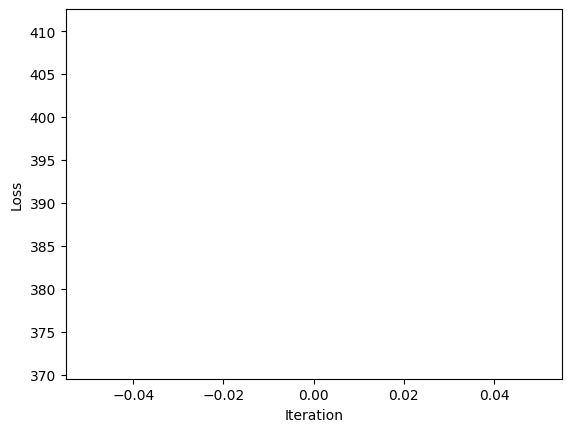

In [ ]:
ii = 0
model = NeuralODE() #42.5
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

losses = []

# get fixed input and fixed label:
X, ved, ves, ef = pvloop_simulator(1.3, 50., 1.7, 0.05, 0.05, 0.02, 10., 70, False, False, False)

for itr in range(1):

    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor
    input = torch.tensor([X[0], X[1], X[2], X[3]])

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    optimizer.zero_grad()
    pred_ved, pred_ves, pred_ef = model(input)
    loss = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if itr % 5 == 0:
      print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

      #if itr % 50 == 0:
      plt.plot(np.arange(len(losses)), losses)
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()

Define the NN interpolator-based model:

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

class Interpolator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(6, 256).double()
        self.fc2 = nn.Linear(256, 2).double()

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = self.fc2(z)
        return z

net = Interpolator()
weights_path = '/content/drive/My Drive/net_weights__weight.pt'
net.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

for name, param in net.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for param in net.parameters(): param.requires_grad = False

class Normalizer1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([0.4, 0., 0.5, 0.02, 0.005, 0.0001], dtype=torch.float32)
        self.upper = torch.tensor([1.7, 280., 3.5, 0.1, 0.1, 0.25], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class Normalizer2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([4.], dtype=torch.float32)
        self.upper = torch.tensor([25.], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(64, 6).double()
        self.fc22 = nn.Linear(64, 1).double()
        self.norm1 = Normalizer1()
        self.norm2 = Normalizer2()
        self.interpolator = net

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        x = self.relu(self.fc1(x))
        pars = self.norm1(self.fc21(x)) #pars: (Tc, startv, emax, emin, rm, ra)
        Vd = self.norm2(self.fc22(x))

        ved, ves = self.interpolator(pars)
        ved = ved + Vd - 4.
        ves = ves + Vd - 4.
        with torch.no_grad(): print(ved+Vd, ves+Vd)

        return ved, ves, (ved - ves) / ved * 100.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu


Create a fixed input (X: input, = LV volumes at 0.2Tc, 0.4Tc, 0.6Tc, 0.8Tc) and fixed label (ef: label)

In [ ]:
X, ved, ves, ef = pvloop_simulator(1.3, 50., 1.7, 0.05, 0.05, 0.02, 10., 70, False, False, False)

Train both models on same fixed input:

Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu
tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)
tensor([[246.6972,  24.6697,  75.0000,  75.0000,   0.0000],
        [196.8239,  33.0862,  84.1020,  84.1876,   3.5182],
        [186.3123,  34.4008,  87.1479,  92.6435, 202.7820]],
       dtype=torch.float64, grad_fn=<OdeintAdjointMethodBackward>) a tensor(200.8239, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(190.3123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([262.7998], dtype=torch.float64) tensor([62.9179], dtype=torch.float64)


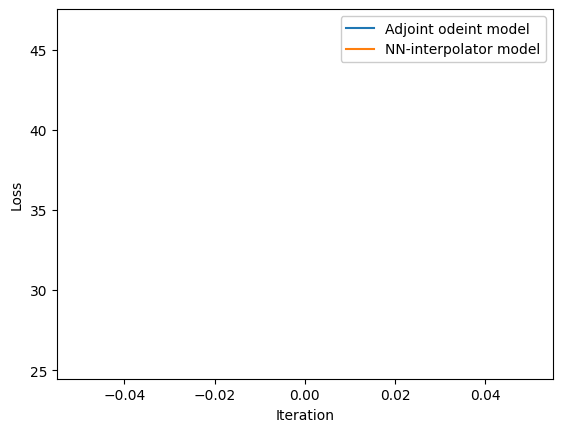

tensor([62.7993, 47.8942, 75.9630, 90.2334], dtype=torch.float64)


AssertionError: ignored

In [ ]:
model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

for name, param in model1.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for itr in range(150):

    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    input = torch.tensor([X[0], X[1], X[2], X[3]])
    print(input)
    #model1:
    optimizer1.zero_grad()
    pred_ved, pred_ves, pred_ef = model1(input)
    #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss1 = torch.abs(pred_ef - true_ef)
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    #model2:
    optimizer2.zero_grad()
    pred_ved, pred_ves, pred_ef = model2(input)
    #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss2 = torch.abs(pred_ef - true_ef)
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 30: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)
    if itr == 60: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-5)

    if itr % 5 == 0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

Train both models on a synthetic dataset of 400 patients (and 50 for testing) taken from the 450 results from the echonet dataset.

Create synthetic dataset:

In [ ]:
n_patients = 450
inputs = torch.zeros(n_patients, 4)
labels = torch.zeros(n_patients, 3)

In [ ]:
inputs[0][1], inputs[0][2] = 1., 10.
print(inputs[0])

tensor([ 0.,  1., 10.,  0.,  0.,  0.])


Create 300 random patients and create their inputs and labels:

First, download outputs_pressures_10024.pt with (ef NN, true ef, paoED, paoES, isperiodic, 1 or 2 if too high pressures)

In [ ]:
!pip install pandas
import pandas as pd

##open:
output_path = '/content/drive/My Drive/'
file = 'outputs_pressures_10024.pt'
outputs_pressures_echo = torch.load(output_path + file)
outputs_pressures_echo = outputs_pressures_echo.numpy()
print(outputs_pressures_echo) #outputs_pressures_echo[i,0]: EF from NN-interpolator, [i,1]: true EF, [i,2]: P_ao(ED), [i,3]: P_ao(ES), [i,4]: isperiodic (0 if is periodic, 1 if is not)
'''
outputs_pressures_echo[i,5]:
if ped>=90. or pes>=140.: outputs_pressures_echo[i][5] = 1 #only if one of both happens
if ped>=90. and pes>=140.: outputs_pressures_echo[i][5] = 2 #if both happen

outputs_pressures_echo: calculated in full_program.ipynb; pao with max and min, ef is exact with Tc etc. all obtained after 60 cycles
'''
# Read the CSV file into a Pandas DataFrame
file_path = 'echo_data.csv'
df = pd.read_csv(file_path)

# Convert the DataFrame to a Python array
data_array = df.values
echo_data = []
for i in range(10024):
  #print(data_array[i][0])
  #p = data_array[i][0].split(" ")
  p = data_array[i]
  pars = [float(p[3]), float(p[4]), float(p[5]), float(p[6]), float(p[7]), float(p[8]), float(p[9])]
  echo_data.append(pars) # (tc, startv, emax, emin, rm, ra, vd)

#df = pd.DataFrame(np.array(echo_data))
print(echo_data)

x = np.arange(10024)
plt.plot(x, outputs_pressures_echo[:, 2], color='blue', label='P_ao(ED)')
plt.plot(x, outputs_pressures_echo[:, 3], color='orange', label='P_ao(ES)')
plt.legend(loc='upper left', framealpha=1)
plt.axhline(y=120, color='r', linestyle='--', label='Horizontal Dashed Line at y=120')
plt.xlabel("Patient index")
plt.ylabel("Pressure (mmHg)")
plt.ylim([40,140])
plt.show()

In [ ]:
print(echo_data)
print(outputs_pressures_echo)

[[1.2845858335494995, 134.086669921875, 2.8635380268096924, 0.0573784485459327, 0.0590610466897487, 0.129396304488182, 10.898351669311523], [1.300397515296936, 140.4815673828125, 2.964420318603516, 0.0586885288357734, 0.0627035796642303, 0.1354421228170395, 11.515802383422852], [1.370150804519653, 126.26031494140624, 3.078831434249877, 0.0536945909261703, 0.0588491186499595, 0.1233144029974937, 10.763874053955078], [0.9659596681594848, 143.73719787597656, 1.7741354703903198, 0.0611476115882396, 0.0580191910266876, 0.1510623842477798, 10.667398452758787], [1.0557334423065183, 136.27999877929688, 2.071239709854125, 0.0601947344839572, 0.0558555163443088, 0.1379286348819732, 10.410383224487305], [1.366755962371826, 126.29521942138672, 3.0655882358551025, 0.0534933060407638, 0.0584309473633766, 0.1200247630476951, 10.793649673461914], [0.8946617841720581, 149.95245361328125, 1.5544754266738892, 0.0621213242411613, 0.0584227889776229, 0.1588708609342575, 10.841979026794432], [1.378584623336

In [ ]:
for i in range(450):
  X, ved, ves, ef = pvloop_simulator(echo_data[i][0], echo_data[i][1], echo_data[i][2], echo_data[i][3], echo_data[i][4], echo_data[i][5], echo_data[i][6], 40, False, False, False)
  if i<10: print(ef, outputs_pressures_echo[i,1])
  if i==25: print(i)

  inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3] = X[0], X[1], X[2], X[3]
  labels[i][0], labels[i][1], labels[i][2] = ved, ves, ef
  #parameters of patient: they are the values of echo_data[i]

61.5463540854911 61.54636603907875
62.35517575892965 62.35518741935835
64.72088107445916 64.72089227622834
40.59393861344604 40.5939574648695
47.866161009955235 47.86617576477695
64.65498337135006 64.65499373367128
34.5986240545554 34.59863811658764
65.03707960948083 65.03709052994812
52.326957321050074 52.32697140300644
63.299498777863526 63.299510205095224
25


Save the data in drive:

In [ ]:
# save points and ved, ves:
output_path = '/content/drive/My Drive/'
file = 'input_450patients_echonet'
torch.save(inputs, os.path.join(output_path,f'{file}.pt'))
file = 'labels_450patients_echonet'
torch.save(labels, os.path.join(output_path,f'{file}.pt'))
print("Saved")

Saved


In [ ]:
# open again:
output_path = '/content/drive/My Drive/'
file = 'input_450patients_echonet.pt'
inputs_dt = torch.load(output_path + file)
file = 'labels_450patients_echonet.pt'
labels_dt = torch.load(output_path + file)
print(inputs_dt, labels_dt)

Using the data, train both models:

In [ ]:
print(x_train.shape)

torch.Size([400, 4])


In [ ]:
import random

In [ ]:
model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

x_train = torch.zeros((400, 4))
y_train = torch.zeros((400, 1))
for i in range(400):
  x_train[i][0], x_train[i][1], x_train[i][2], x_train[i][3] = inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3]
  y_train[i][0] = labels[i][2]
x_train = torch.tensor(x_train, dtype = torch.float64)
y_train = torch.tensor(y_train, dtype = torch.float64)
n_itrs = 400

for itr in range(n_itrs):
    ## TO CHANGE: change the next line to have input = processed video / batch viewed as torch tensor

    ## TO CHANGE: change the next line to have true_ved, true_ves, true_ef = true labels of the video / batch
    true_ved, true_ves, true_ef = torch.tensor(ved), torch.tensor(ves), torch.tensor(ef)

    j = itr #random.randint(0,400)

    optimizer1.zero_grad()
    pred_ved, pred_ves, pred_ef = model1(x_train[j])
    #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss1 = torch.abs(pred_ef - y_train[j][0])
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    optimizer2.zero_grad()
    #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    pred_ved, pred_ves, pred_efs = model2(x_train[j])
    loss2 = torch.abs(pred_efs - y_train[j][0])
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 35: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-5)
    if itr == 60: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-6)

    if itr % 10 == 0 and itr>0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

In [ ]:
print(itr)

0
